In [ ]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO
import pandas as pd
import pickle


from util import *
from plotting_helpers import *
from generation import *

# === CONFIG ===
current_dir = os.path.dirname(os.getcwd())
FILE_PATH = os.path.join(current_dir, "data", "IBM", "HI-SmallTransactions.txt")


current_dir = os.path.dirname(os.getcwd())
CSV_PATH = os.path.join(current_dir, "data", "IBM", "Hi-Small_Trans.csv")


pattern_dict = create_pattern_dict(FILE_PATH)

bipartite_data = filter_dict(pattern_dict, "BIPARTITE" )  # Example usage function

df_data = pd.DataFrame(bipartite_data, columns=columns)
df_data['src'] = df_data['From Bank'] + "_" + df_data['From Account']
df_data['dst'] = df_data['To Bank'] + "_" + df_data['To Account']


Looking for file at:
c:\Users\lucsc\Thesis\grad\grad\data\IBM\HI-SmallTransactions.txt



In [2]:
df_data.sort_values(by=['src'], inplace=True)
len(df_data['dst'].unique())

# 1. detect duplicates inside each column
dup_col1 = df_data['src'].duplicated(keep=False)
dup_col2 = df_data['dst'].duplicated(keep=False)

# 2. detect values that appear in BOTH columns
values_in_both = df_data['src'].isin(df_data['dst']) | df_data['dst'].isin(df_data['src'])

# 3. final mask: keep rows where ANY of the above is true
mask = dup_col1 | dup_col2 | values_in_both

df_filtered = df_data[mask]

plot_laundering_pattern("duplicate bipartite filtered", df_filtered.values.tolist())

✅ Saved plot for 'duplicate bipartite filtered' to: c:\Users\lucsc\Thesis\grad\grad\dataprep\pattern_plots\duplicate_bipartite_filtered.png


In [3]:
plot_laundering_pattern("STACKfiltered", df_filtered.values.tolist())

✅ Saved plot for 'STACKfiltered' to: c:\Users\lucsc\Thesis\grad\grad\dataprep\pattern_plots\STACKfiltered.png


In [4]:
# Load your data first

df_full = pd.read_csv(CSV_PATH, dtype=str)
df_full["Is Laundering"] = pd.to_numeric(df_full["Is Laundering"], errors="coerce").fillna(2).astype(int)
df = df_full[df_full['Is Laundering'] ==1]

df_full["From_Node"] = df_full["From Bank"].astype(str) + "_" + df_full["Account"].astype(str)
df_full["To_Node"] = df_full["To Bank"].astype(str) + "_" + df_full["Account.1"].astype(str)

# full_data["Amount Paid"] = full_data["Amount Paid"].astype(float)
# full_data["Amount Received"] = full_data["Amount Received"].astype(float)

df["From_Node"] = df["From Bank"].astype(str) + "_" + df["Account"].astype(str)
df["To_Node"] = df["To Bank"].astype(str) + "_" + df["Account.1"].astype(str)

START_ACCOUNT = "0222_812D127D0"


connected_df, connected_nodes = gather_suspicious_network(df, start_node=START_ACCOUNT)

print(f"Found {len(connected_nodes)} suspicious connected nodes")
print(f"Found {len(connected_df)} suspicious related transactions")

# Visualize the suspicious network
visualize_suspicious_network(connected_df, start_node=START_ACCOUNT)


C:\Users\lucsc\AppData\Local\Temp\ipykernel_22136\2932867589.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["From_Node"] = df["From Bank"].astype(str) + "_" + df["Account"].astype(str)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_22136\2932867589.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["To_Node"] = df["To Bank"].astype(str) + "_" + df["Account.1"].astype(str)
c:\Users\lucsc\Thesis\grad\grad\dataprep\plotting_helpers.py:167: UserWarning: This figure includes Axes that are not compatib

Found 2 suspicious connected nodes
Found 10 suspicious related transactions
📈 Saved visualization to suspicious_plots\suspicious_network_0222_812D127D0.png


In [6]:
all_nodes = set(df["From_Node"]).union(set(df["To_Node"]))

def process_all_suspicious_networks(df):
    """
    Iteratively discovers suspicious networks without reusing nodes.
    """

    all_nodes = set(df["From_Node"]).union(set(df["To_Node"]))
    unvisited_nodes = set(all_nodes)
    global_seen_nodes = set()

    networks = []  # store results

    while unvisited_nodes:
        start_node = unvisited_nodes.pop()

        # Skip if already covered
        if start_node in global_seen_nodes:
            continue

        connected_df, connected_nodes = gather_suspicious_network(
            df,
            start_node=start_node
        )

        # If nothing suspicious found, just mark visited
        if not connected_nodes:
            global_seen_nodes.add(start_node)
            continue

        # Store result
        networks.append({
            "start_node": start_node,
            "nodes": connected_nodes,
            "transactions": connected_df
        })

        # Mark all discovered nodes as globally seen
        global_seen_nodes.update(connected_nodes)

        # Remove them from future start-node consideration
        unvisited_nodes.difference_update(connected_nodes)

        print(
            f"Network from {start_node}: "
            f"{len(connected_nodes)} nodes, "
            f"{len(connected_df)} transactions"
        )

    return networks


In [7]:
df = df[df['Is Laundering'] ==1]

networks = process_all_suspicious_networks(df)

print(f"\nDiscovered {len(networks)} unique suspicious networks\n")

# for i, net in enumerate(networks, 1):
#     print(
#         f"[{i}] Start node: {net['start_node']} | "
#         f"Nodes: {len(net['nodes'])} | "
#         f"Transactions: {len(net['transactions'])}"
#     )
#     if len(net['nodes']) > 3:
#         visualize_suspicious_network(
#             net["transactions"],
#             start_node=net["start_node"]
#         )


Network from 019474_80DA6F420: 10 nodes, 16 transactions
Network from 0053160_813908380: 241 nodes, 247 transactions
Network from 0021615_8083E2D60: 2 nodes, 1 transactions
Network from 00701_80408AC50: 2 nodes, 2 transactions
Network from 009328_803682670: 2 nodes, 1 transactions
Network from 01490_8018B5A10: 12 nodes, 19 transactions
Network from 0025534_80963CB30: 3 nodes, 2 transactions
Network from 0227143_80B6EACF0: 3 nodes, 2 transactions
Network from 012_80084A830: 200 nodes, 212 transactions
Network from 027217_805AC5390: 28 nodes, 27 transactions
Network from 0021922_8080A3C50: 190 nodes, 191 transactions
Network from 002845_802B8AAB0: 2 nodes, 1 transactions
Network from 008771_805590E80: 2 nodes, 1 transactions
Network from 01292_8034CDEA0: 2 nodes, 1 transactions
Network from 0021568_807DEAE80: 28 nodes, 27 transactions
Network from 0142836_80FE13FA0: 30 nodes, 29 transactions
Network from 003698_80C81A1D0: 2 nodes, 1 transactions
Network from 029715_80C2D6120: 25 nodes, 2

In [8]:
networks[3]

{'start_node': '00701_80408AC50',
 'nodes': {'001665_801C602A0', '00701_80408AC50'},
 'transactions':                 Timestamp From Bank    Account To Bank  Account.1  \
 1920309  2022/09/03 04:11    001665  801C602A0   00701  80408AC50   
 1920311  2022/09/06 02:11     00701  80408AC50  001665  801C602A0   
 
         Amount Received Receiving Currency Amount Paid Payment Currency  \
 1920309        17202.02          US Dollar    17202.02        US Dollar   
 1920311        13244.48               Euro    13244.48             Euro   
 
         Payment Format  Is Laundering         From_Node           To_Node  
 1920309            ACH              1  001665_801C602A0   00701_80408AC50  
 1920311            ACH              1   00701_80408AC50  001665_801C602A0  }

In [9]:
import random

transactions = networks[3]["transactions"]

transactions['time_diff'] = pd.to_datetime(transactions['Timestamp']) - pd.to_datetime(transactions['Timestamp'].shift(1))
total_time = transactions['time_diff'].sum()\

random.randint(0, len(transactions))

1

In [10]:
transactions

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,From_Node,To_Node,time_diff
1920309,2022/09/03 04:11,001665,801C602A0,00701,80408AC50,17202.02,US Dollar,17202.02,US Dollar,ACH,1,001665_801C602A0,00701_80408AC50,NaT
1920311,2022/09/06 02:11,00701,80408AC50,001665,801C602A0,13244.48,Euro,13244.48,Euro,ACH,1,00701_80408AC50,001665_801C602A0,2 days 22:00:00


In [11]:
net = networks[3]
print(
    f"[1] Start node: {net['start_node']} | "
    f"Nodes: {len(net['nodes'])} | "
    f"Transactions: {len(net['transactions'])}"
)

visualize_suspicious_network(
    net["transactions"],
    start_node=net["start_node"],
    save_folder="tests"
)

[1] Start node: 00701_80408AC50 | Nodes: 2 | Transactions: 2


c:\Users\lucsc\Thesis\grad\grad\dataprep\plotting_helpers.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


📈 Saved visualization to tests\suspicious_network_00701_80408AC50.png


00701_80408AC50 001665_801C602A0
Pattern nodes: ['070_DD0EBAA0', '0119_47E0C1720', '002053_2F4899E20', '0115700_21B988460', '003_7BA1CAA0']


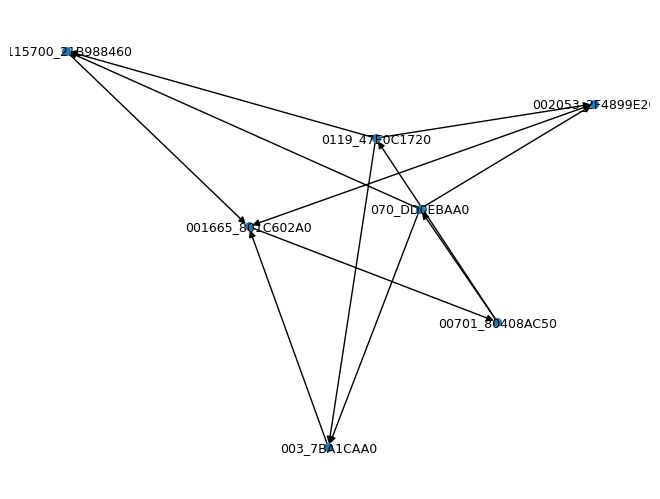

In [12]:
# Create a directed graph
G = nx.from_pandas_edgelist(
    transactions,
    source="From_Node",
    target="To_Node",
    create_using=nx.DiGraph()
)
u,v = random.choice(list(G.edges()))
print(u,v)
G.remove_edge(u, v)

pattern_graph, pos = generate_pattern('Bipartite')

pattern_nodes = list(pattern_graph.nodes())
print("Pattern nodes:", pattern_nodes)
in_degrees = dict(pattern_graph.in_degree())
out_degrees = dict(pattern_graph.out_degree())

entry_nodes = [n for n in pattern_nodes if in_degrees[n] == 0]
exit_nodes  = [n for n in pattern_nodes if out_degrees[n] == 0]

for n in pattern_nodes:
    G.add_node(n)

for x, y, data in pattern_graph.edges(data=True):
    G.add_edge(x, y, laundering=1)

for n in entry_nodes:
    G.add_edge(u, n, laundering=1)

for n in exit_nodes:
    G.add_edge(n, v, laundering=1)

# graph, pos, pattern_type = generate_pattern_in_graph(G, pattern_type="Bipartite")

nx.draw(
    G,
    with_labels=True,
    node_size=30,
    font_size=9,
    arrows=True,
)

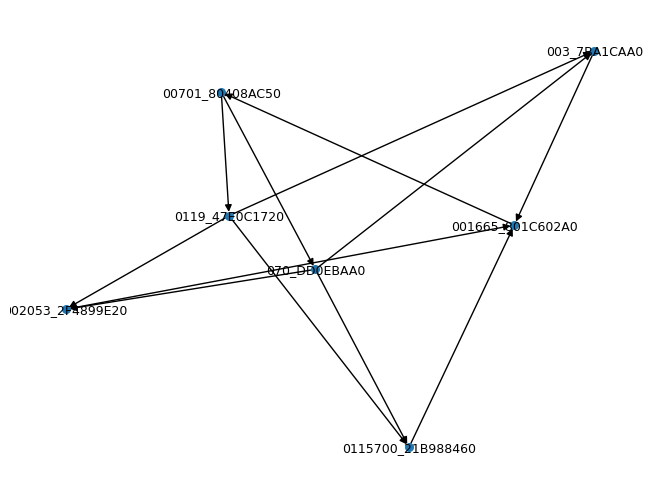

In [13]:
nx.draw(
    G,
    with_labels=True,
    node_size=30,
    font_size=9,
    arrows=True,
)

In [14]:
G, pos = generate_pattern(pattern_type="Bipartite", n_left=2, n_right=3, laudering=1
                 )

# plot_generated_data(G, pos)

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_network(
    df,
    start_node,
    max_depth=5,
    collapse_threshold=10
):
    """
    Visualize transaction network starting from a given node,
    coloring nodes based on Is Laundering label.
    """

    G = nx.DiGraph()
    visited = set()
    node_laundering_flag = {}

    def is_node_laundering(node):
        """Return True if node appears in any laundering transaction"""
        return not df[
            ((df["From_Node"] == node) | (df["To_Node"] == node)) &
            (df["Is Laundering"] == 1)
        ].empty

    def recurse(node, depth):
        if depth > max_depth or node in visited:
            return

        visited.add(node)

        # Store laundering flag
        node_laundering_flag[node] = is_node_laundering(node)

        outgoing = df[df["From_Node"] == node]["To_Node"].tolist()
        incoming = df[df["To_Node"] == node]["From_Node"].tolist()
        neighbors = set(outgoing + incoming)
        # print(neighbors)
        # Collapse highly connected nodes
        if len(neighbors) > collapse_threshold:
            summary_node = f"{node}\n(+{len(neighbors)} connections)"
            G.add_node(summary_node)
            node_laundering_flag[summary_node] = None  # summary node
            G.add_edge(node, summary_node)
            return

        for nbr in neighbors:
            node_laundering_flag[nbr] = is_node_laundering(nbr)

            if not df[
                (df["From_Node"] == node) &
                (df["To_Node"] == nbr)
            ].empty:
                G.add_edge(node, nbr)

            if not df[
                (df["From_Node"] == nbr) &
                (df["To_Node"] == node)
            ].empty:
                G.add_edge(nbr, node)

            recurse(nbr, depth + 1)

    recurse(start_node, depth=0)

    # ---- Node coloring ----
    node_colors = []
    for node in G.nodes():
        flag = node_laundering_flag.get(node)
        if flag is True:
            node_colors.append("red")      # laundering
        elif flag is False:
            node_colors.append("lightblue") # clean
        else:
            node_colors.append("gray")     # collapsed node

    edge_colors = []
    for u, v in G.edges():
        if (
            node_laundering_flag.get(u) is True and
            node_laundering_flag.get(v) is True
        ):
            edge_colors.append("red")   # laundering-to-laundering
        else:
            edge_colors.append("gray")  # default

    # ---- Visualization ----
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.8, seed=42)

    nx.draw(
        G,
        # pos,
        with_labels=True,
        node_size=1000,
        node_color=node_colors,
        edge_color=edge_colors,
        font_size=8,
        arrows=True
    )

    plt.title(
        f"Transaction Network from {start_node}\n"
        "Red = Laundering-related | Blue = Normal | Gray = Collapsed",
        fontsize=14
    )
    plt.show()


In [16]:
# visualize_transaction_network(
#     df_full,
#     start_node="0111433_8065C2380",
#     max_depth=4,
#     collapse_threshold=10
# )

In [17]:
import pandas as pd
from collections import deque

def extract_laundering_networks(
    df,
    max_depth=5,
    max_networks=10,
    collapse_threshold=10
):
    """
    Extract laundering-centered networks with surrounding non-laundering nodes.
    Returns a list of dictionaries (not graphs).
    """

    networks = []
    seen_laundering_nodes = set()

    # --- Identify laundering nodes ---
    laundering_df = df[df["Is Laundering"] == 1]
    laundering_nodes = set(laundering_df["From_Node"]) | set(laundering_df["To_Node"])

    # --- Helper ---
    def is_node_laundering(node):
        return not df[
            ((df["From_Node"] == node) | (df["To_Node"] == node)) &
            (df["Is Laundering"] == 1)
        ].empty

    def expand_from_laundering(start_node):
        """
        BFS expansion from a laundering node, allowing non-laundering nodes,
        limited by max_depth from laundering origin.
        """

        visited = {}
        collapsed_nodes = set()
        queue = deque([(start_node, 0)])

        while queue:
            node, depth = queue.popleft()

            if node in visited:
                continue

            visited[node] = depth

            # Neighbors from full transaction graph
            outgoing = df[df["From_Node"] == node]["To_Node"].tolist()
            incoming = df[df["To_Node"] == node]["From_Node"].tolist()
            neighbors = set(outgoing + incoming)
            print(neighbors)
            # Collapse highly connected nodes
            if len(neighbors) > collapse_threshold:
                collapsed_nodes.add(node)
                continue

            # Depth control (distance from laundering origin)
            if depth >= max_depth:
                continue

            for nbr in neighbors:
                if nbr not in visited:
                    queue.append((nbr, depth + 1))

        return visited, collapsed_nodes

    # --- Build laundering-centered networks ---
    for start_node in laundering_nodes:
        if start_node in seen_laundering_nodes:
            continue

        visited_nodes, collapsed_nodes = expand_from_laundering(start_node)

        # Mark laundering nodes in this component as seen
        laundering_in_component = {
            n for n in visited_nodes if is_node_laundering(n)
        }
        seen_laundering_nodes.update(laundering_in_component)

        # Extract transactions inside this network
        component_nodes = set(visited_nodes.keys())

        transactions = df[
            df["From_Node"].isin(component_nodes) &
            df["To_Node"].isin(component_nodes)
        ].copy()

        network = {
            "start_node": start_node,
            "nodes": component_nodes,
            "laundering_nodes": laundering_in_component,
            "collapsed_nodes": collapsed_nodes,
            "node_depths": visited_nodes,   # distance from laundering start
            "transactions": transactions
        }

        networks.append(network)

        if len(networks) >= max_networks:
            break

    return networks


In [19]:
with_laund_nets = extract_laundering_networks(df_full, max_depth=3, max_networks=1, collapse_threshold=15)

{'01292_800BB73D0', '019474_80DA6F420', '0224782_80B1782D0', '001047_800BE2BB0', '004523_80D1F9020', '0210261_803B8BFC0', '007675_8093BA230'}
{'01292_800BB73D0', '019474_80DA6F420', '0138133_811187CF0', '029251_80E0D0A40', '001_800327650', '0024869_810A3DFB0', '01588_8003F7910'}
{'014_80D9A68A0', '004_80B176CC0', '019474_80DA6F420', '0219194_8036B31E0', '0013649_80EF89700', '0136651_80EC82850', '0245611_8137C3EB0', '005627_80BBB4690', '0224782_80B1782D0', '014_803095D30', '018196_8137C0330', '0239654_813BEBB00', '029788_80EF4C6C0', '0245611_812E2BC40'}
{'016031_805E02A10', '01467_800BE2B60', '019474_80DA6F420', '01420_8010003E0', '0012446_8079E1640', '0032814_80C87A9F0', '0228921_812741660', '001457_8032893D0', '0016606_80A3A38C0', '001047_800BE2BB0', '015730_808892620', '0148543_8120AF050', '016788_80439EDF0', '013327_8015F18C0', '0214609_80DD54E80', '028771_805547660', '002385_800F31460', '008354_80DD54ED0'}
{'019474_80DA6F420', '0127390_80D27B630', '0121303_80EF06B30', '0211075_80D1

In [ ]:
with open("with_laund_networks.pkl", 'rb') as f:
    with_laund_nets = pickle.load(f)

In [ ]:
df_full[df_full['To_Node'] == '016254_80AB93D20']

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,From_Node,To_Node
165534,2022/09/01 00:21,016254,80AB93D20,016254,80AB93D20,15.13,Euro,15.13,Euro,Reinvestment,0,016254_80AB93D20,016254_80AB93D20
955791,2022/09/01 19:19,016254,80AB93D20,016254,80AB93D20,2016.47,Euro,2016.47,Euro,Reinvestment,0,016254_80AB93D20,016254_80AB93D20
1739487,2022/09/02 19:48,0329518,80AB8EBF0,016254,80AB93D20,332.47,Euro,332.47,Euro,ACH,0,0329518_80AB8EBF0,016254_80AB93D20
3262913,2022/09/07 00:22,0117698,80D8F25A0,016254,80AB93D20,10.56,Euro,10.56,Euro,Credit Card,0,0117698_80D8F25A0,016254_80AB93D20
4369756,2022/09/09 05:28,0329518,80AB8EBF0,016254,80AB93D20,332.47,Euro,332.47,Euro,ACH,0,0329518_80AB8EBF0,016254_80AB93D20
5008199,2022/09/10 15:09,001665,80AB8EDC0,016254,80AB93D20,1917.67,Euro,1917.67,Euro,ACH,0,001665_80AB8EDC0,016254_80AB93D20
5008200,2022/09/10 15:02,008455,80AB935A0,016254,80AB93D20,977.79,Euro,977.79,Euro,ACH,0,008455_80AB935A0,016254_80AB93D20
5008201,2022/09/10 15:11,017649,80AB93110,016254,80AB93D20,1203.04,Euro,1203.04,Euro,ACH,0,017649_80AB93110,016254_80AB93D20
5008202,2022/09/10 15:06,0225690,80AB8C550,016254,80AB93D20,1945.69,Euro,1945.69,Euro,ACH,0,0225690_80AB8C550,016254_80AB93D20
5008203,2022/09/10 15:10,027103,80AB8C1E0,016254,80AB93D20,2770.05,Euro,2770.05,Euro,ACH,0,027103_80AB8C1E0,016254_80AB93D20


In [ ]:
with_laund_nets[0]['transactions']

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,From_Node,To_Node
941,2022/09/01 00:08,001,800268220,017729,802EAF7D0,34.68,US Dollar,34.68,US Dollar,Credit Card,0,001_800268220,017729_802EAF7D0
3918,2022/09/01 00:07,010,8006D8580,010,8006D8580,7965.68,US Dollar,7965.68,US Dollar,Reinvestment,0,010_8006D8580,010_8006D8580
3923,2022/09/01 00:01,010,8006D8580,010,8006D8580,17.46,US Dollar,17.46,US Dollar,Reinvestment,0,010_8006D8580,010_8006D8580
14190,2022/09/01 00:25,011813,8018476F0,011813,8018476F0,5892.87,US Dollar,5892.87,US Dollar,Reinvestment,0,011813_8018476F0,011813_8018476F0
14609,2022/09/01 00:07,004242,801920890,004242,801920890,18.94,US Dollar,18.94,US Dollar,Reinvestment,0,004242_801920890,004242_801920890
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062156,2022/09/10 21:58,0116,80DD81E50,0138395,80E5C5420,0.39,Swiss Franc,0.39,Swiss Franc,Credit Card,0,0116_80DD81E50,0138395_80E5C5420
5064303,2022/09/10 22:03,070,1004286A8,015055,802594E00,1120.13,Euro,1120.13,Euro,Cheque,0,070_1004286A8,015055_802594E00
5064304,2022/09/10 22:25,070,1004286A8,015055,802594E00,5413.48,Euro,5413.48,Euro,Credit Card,0,070_1004286A8,015055_802594E00
5064305,2022/09/10 22:24,070,1004286A8,015055,802594E00,3393.98,Euro,3393.98,Euro,Cash,0,070_1004286A8,015055_802594E00


In [ ]:
amount_nodes = 0
avg_transactions = 0
for i in range(len(with_laund_nets)):
    net = with_laund_nets[i]
    amount_nodes += len(net['nodes']) 
    avg_transactions += len(net['transactions'])

avg_transactions = avg_transactions / len(with_laund_nets)
avg_nodes = amount_nodes / len(with_laund_nets)
print(f"Extracted {len(with_laund_nets)} laundering networks")
print(f"Average nodes per network: {avg_nodes:.2f}")    
print(f"Average transactions per network: {avg_transactions:.2f}")

Extracted 1881 laundering networks
Average nodes per network: 3.60
Average transactions per network: 17.02


In [ ]:
with_laund_nets[0]

{'start_node': '016254_80AB93D20',
 'nodes': {'0010060_803ED04F0',
  '001024_801821060',
  '0010441_80C8E4AF0',
  '0010709_808078C90',
  '0010709_80C08F150',
  '0010_80CDEF520',
  '0012461_80AB8C190',
  '001267_8007C7660',
  '001299_813583150',
  '0014233_80C536DE0',
  '0014254_80BA7DAA0',
  '0014254_80C0BCEB0',
  '0014277_810320000',
  '0014277_812B57D40',
  '0015_80AFE44E0',
  '001655_80B4E2490',
  '001665_801D372E0',
  '001665_80AB8EDC0',
  '001669_800B97410',
  '0017174_806CD22B0',
  '0018180_807B6E150',
  '001916_80AB8C810',
  '0019542_8134DC2D0',
  '001_800268220',
  '0020727_80AB8ED70',
  '0021142_80BD06950',
  '0021922_80BF374E0',
  '00220_8002680E0',
  '0023554_80C79E0D0',
  '002467_80107E360',
  '0027365_80B3D49E0',
  '0027402_812DB4E80',
  '0027621_80A286A20',
  '0027621_80A288130',
  '0027621_80A9E6B10',
  '0027621_80AA60600',
  '0027755_80A25CD80',
  '0027755_80A458FA0',
  '0027755_80A808D40',
  '0028094_80A460390',
  '0028416_80AD557D0',
  '0028603_80A957200',
  '0028768_

In [ ]:
from plotting_helpers import *

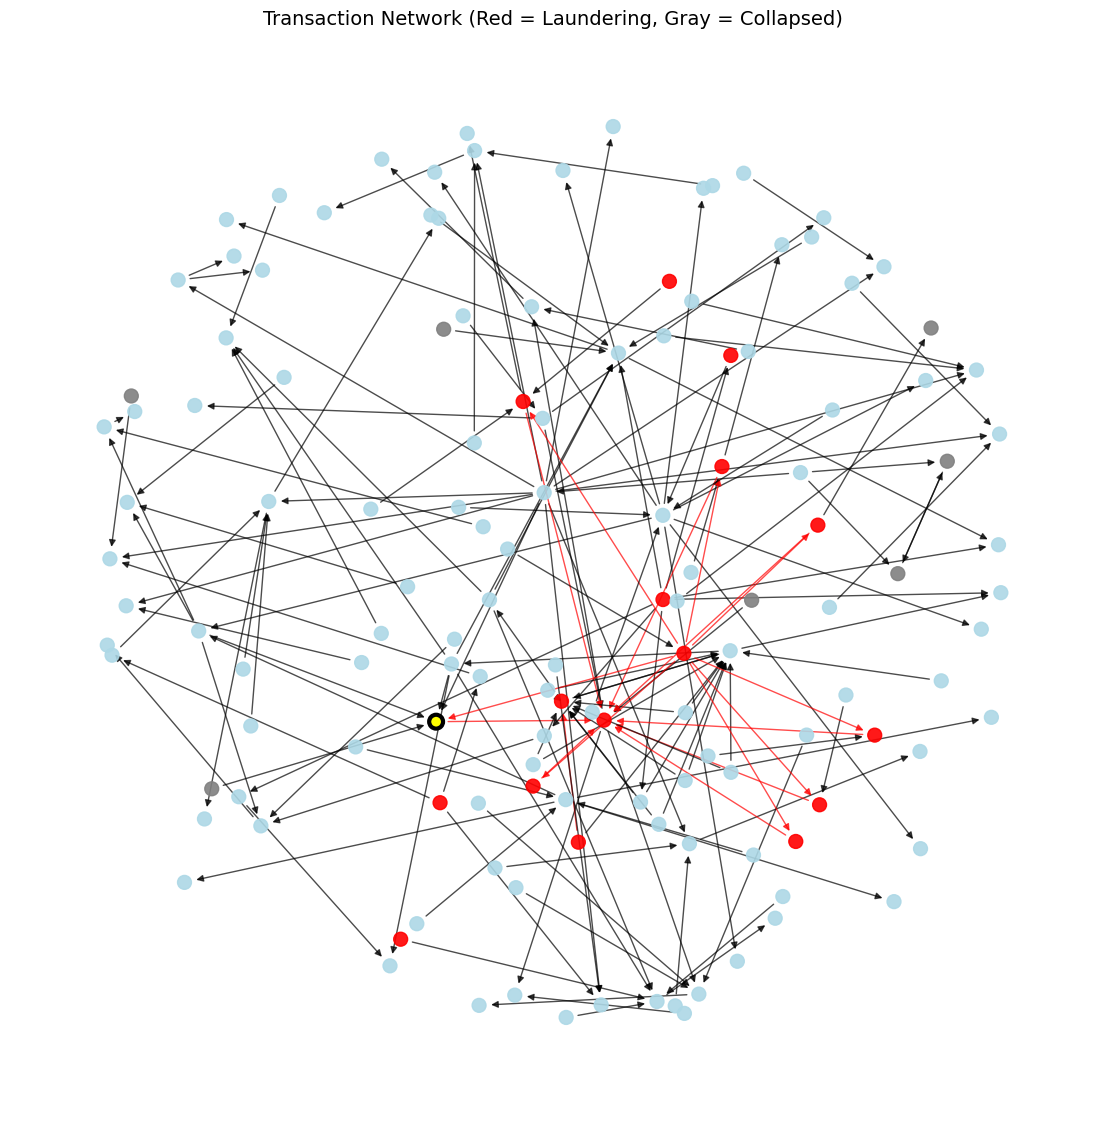

In [23]:
plot_graph_from_dict(with_laund_nets[0], save_path="tests/laundering_graph.png")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os

# ----------------------------------------------------
# 1. Load tuple-list data from your dict
# ----------------------------------------------------
data = pattern_dict["STACK"]

cols = [
    "timestamp", "sender_id", "sender_acct", "receiver_id", "receiver_acct",
    "amount", "currency", "amount2", "currency2", "method", "flag"
]

df = pd.DataFrame(data, columns=cols)

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["amount"] = df["amount"].astype(float)

# Strip whitespace, convert to string
for col in ["sender_id", "sender_acct", "receiver_id", "receiver_acct"]:
    df[col] = df[col].astype(str).str.strip()

entity_path = os.path.join(current_dir, "data", "IBM", "Hi-Small_accounts.csv")
entity_df = pd.read_csv(entity_path, dtype=str)

for col in ["Bank ID", "Account Number"]:
    entity_df[col] = entity_df[col].astype(str).str.strip()

# --- Clean IDs: remove leading zeros ---
df["sender_id"]   = df["sender_id"].astype(str).str.lstrip("0")
df["receiver_id"] = df["receiver_id"].astype(str).str.lstrip("0")

entity_df["Bank ID"] = entity_df["Bank ID"].astype(str).str.lstrip("0")

df["From_Node"] = df["sender_id"] + "_" + df["sender_acct"]
df["To_Node"]   = df["receiver_id"] + "_" + df["receiver_acct"]

entity_df["bank_id"] = entity_df["Bank ID"] + "_" + entity_df["Account Number"]

# Debug print example keys
print("\nExample From_Node:", df["From_Node"].iloc[0])
print("Example To_Node:  ", df["To_Node"].iloc[0])
print("\nExample bank_id:", entity_df["bank_id"].iloc[0])

# ----------------------------------------------------
# 5. Merge sender entity
# ----------------------------------------------------
merged_df = df.merge(
    entity_df[['bank_id', 'Entity ID']],
    how='left',
    left_on='From_Node',
    right_on='bank_id'
).rename(columns={'Entity ID': 'sender_entity'}).drop(columns=['bank_id'])

# ----------------------------------------------------
# 6. Merge receiver entity
# ----------------------------------------------------
merged_df = merged_df.merge(
    entity_df[['bank_id', 'Entity ID']],
    how='left',
    left_on='To_Node',
    right_on='bank_id'
).rename(columns={'Entity ID': 'receiver_entity'}).drop(columns=['bank_id'])

# ----------------------------------------------------
# 7. Preview result
# ----------------------------------------------------
# print("\nMerged result preview:")
print(merged_df.head())



Example From_Node: 223_8000DD890
Example To_Node:   40312_80F52D550

Example bank_id: 331579_80B779D80
            timestamp sender_id sender_acct receiver_id receiver_acct  \
0 2022-09-02 12:36:00       223   8000DD890       40312     80F52D550   
1 2022-09-03 19:52:00     40312   80F52D550       23370     80BEA98A0   
2 2022-09-01 10:19:00     18617   8038D3520       24482     801C0F2B0   
3 2022-09-03 05:06:00     24482   801C0F2B0         214     80C1B9E20   
4 2022-09-01 09:22:00     40836   80F6B88B0       16606     8064545E0   

      amount      currency    amount2     currency2 method flag  \
0   14153.46   Swiss Franc   14153.46   Swiss Franc    ACH    1   
1   11975.53      UK Pound   11975.53      UK Pound    ACH    1   
2   13712.96          Euro   13712.96          Euro    ACH    1   
3  333126.09  Mexican Peso  333126.09  Mexican Peso    ACH    1   
4   11800.69     US Dollar   11800.69     US Dollar    ACH    1   

         From_Node          To_Node sender_entity rece

In [ ]:
entity_df.head()


,Bank Name,Bank ID,Account Number,Entity ID,Entity Name,bank_id
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438,331579_80B779D80
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520,210_809D86900
2,UK Bank #33,21884,80812BE00,800C47F50,Partnership #35397,21884_80812BE00
3,Germany Bank #4815,32742,81047F300,80096F0B0,Corporation #48813,32742_81047F300
4,National Bank of Harrisburg,127390,80BD8CF00,800FB8760,Corporation #889,127390_80BD8CF00


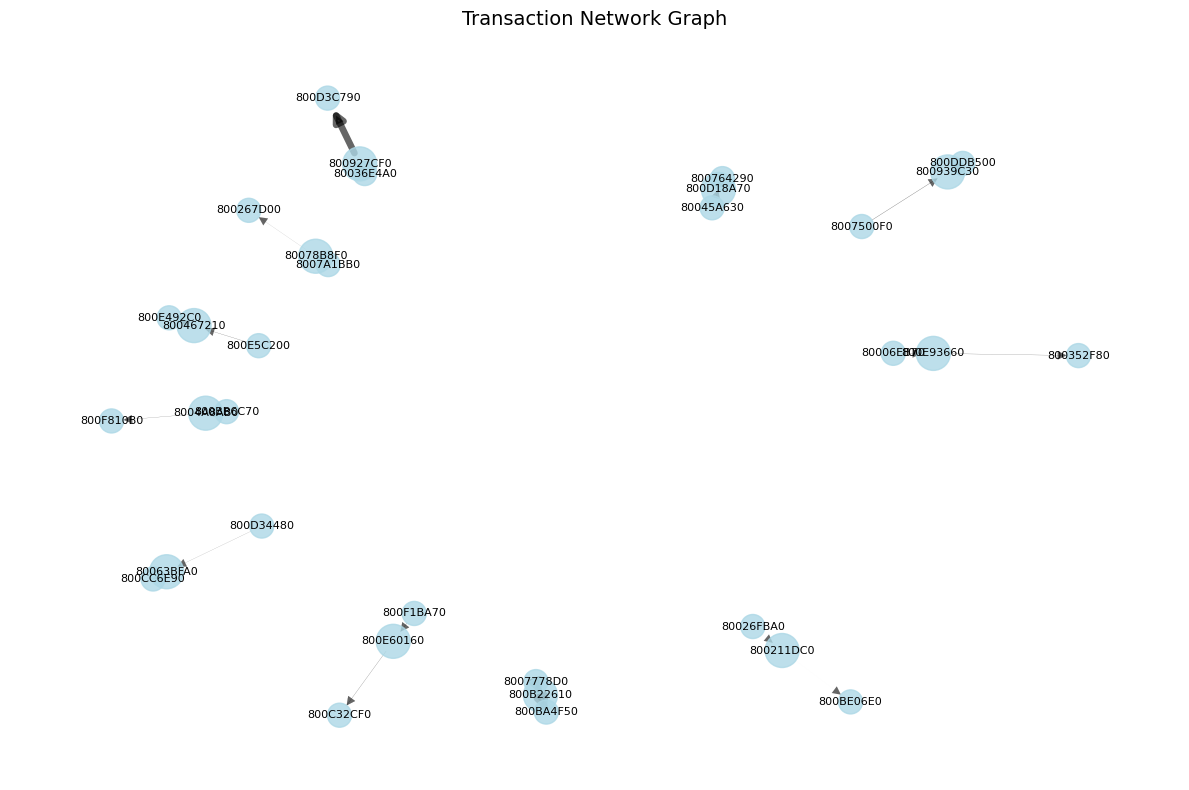

In [ ]:
# --- Create directed graph ---
G = nx.DiGraph()

for _, row in merged_df.iterrows():
    sender = row["sender_entity"]
    receiver = row["receiver_entity"]
    amount = row["amount"]
    currency = row["currency"]
    
    # Add weighted edge
    if G.has_edge(sender, receiver):
        G[sender][receiver]["weight"] += amount
    else:
        G.add_edge(sender, receiver, weight=amount, currency=currency)

# --- Node sizes & edge widths ---
node_sizes = [G.degree(n) * 300 for n in G.nodes()]
edge_weights = [G[u][v]['weight'] / max(merged_df['amount']) * 5 for u, v in G.edges()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Transaction Network Graph", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Ensure output directory exists
output_dir = os.path.join(current_dir, "entity_pattern_plots")
os.makedirs(output_dir, exist_ok=True)

# Load entity dataframe
entity_path = os.path.join(current_dir, "data", "IBM", "Hi-Small_accounts.csv")
entity_df = pd.read_csv(entity_path, dtype=str)
entity_df["Bank ID"] = entity_df["Bank ID"].astype(str).str.lstrip("0")

entity_df["bank_id"] = entity_df["Bank ID"].astype(str) + "_" + entity_df["Account Number"].astype(str)
print(entity_df.head())
cols = [
    "timestamp", "sender_id", "sender_acct", "receiver_id", "receiver_acct",
    "amount", "currency", "amount2", "currency2", "method", "flag"
]

for pattern_name, pattern_data in pattern_dict.items():
    # --- Parse into DataFrame ---
    df = pd.DataFrame(pattern_data)
    df.columns = cols

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["amount"] = df["amount"].astype(float)
    df["sender_id"]   = df["sender_id"].astype(str).str.lstrip("0")
    df["receiver_id"] = df["receiver_id"].astype(str).str.lstrip("0")

    df["From_Node"] = df["sender_id"].astype(str) + "_" + df["sender_acct"].astype(str)
    df["To_Node"] = df["receiver_id"].astype(str) + "_" + df["receiver_acct"].astype(str)

    # Merge sender entity
    merged_df = df.merge(
        entity_df[['bank_id', 'Entity ID']],
        how='left',
        left_on='From_Node',
        right_on='bank_id'
    ).rename(columns={'Entity ID': 'sender_entity'}).drop('bank_id', axis=1)

    # Merge receiver entity
    merged_df = merged_df.merge(
        entity_df[['bank_id', 'Entity ID']],
        how='left',
        left_on='To_Node',
        right_on='bank_id'
    ).rename(columns={'Entity ID': 'receiver_entity'}).drop('bank_id', axis=1)

    # --- Create directed graph ---
    G = nx.DiGraph()
    for _, row in merged_df.iterrows():
        sender = row["sender_entity"]
        receiver = row["receiver_entity"]
        amount = row["amount"]
        currency = row["currency"]

        if pd.isna(sender) or pd.isna(receiver):
            continue  # Skip if entity mapping is missing

        if G.has_edge(sender, receiver):
            G[sender][receiver]["weight"] += amount
        else:
            G.add_edge(sender, receiver, weight=amount, currency=currency)

    # --- Node sizes & edge widths ---
    node_sizes = [G.degree(n) * 300 for n in G.nodes()]
    max_amount = merged_df['amount'].max()
    edge_weights = [G[u][v]['weight'] / max_amount * 5 for u, v in G.edges()]

    # --- Plot graph ---
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Transaction Network Graph - {pattern_name}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, f"{pattern_name}.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()

print(f"All plots saved in: {output_dir}")


                     Bank Name Bank ID Account Number  Entity ID  \
0          Portugal Bank #4507  331579      80B779D80  80062E240   
1              Canada Bank #27     210      809D86900  800C998A0   
2                  UK Bank #33   21884      80812BE00  800C47F50   
3           Germany Bank #4815   32742      81047F300  80096F0B0   
4  National Bank of Harrisburg  127390      80BD8CF00  800FB8760   

                  Entity Name           bank_id  
0  Sole Proprietorship #50438  331579_80B779D80  
1          Corporation #33520     210_809D86900  
2          Partnership #35397   21884_80812BE00  
3          Corporation #48813   32742_81047F300  
4            Corporation #889  127390_80BD8CF00  


C:\Users\lucsc\AppData\Local\Temp\ipykernel_3900\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_3900\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_3900\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrowsize=15)
C:\Users\lucsc\AppData\Local\Temp\ipykernel_3900\835388537.py:77: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.d

All plots saved in: c:\Users\lucsc\Thesis\grad\grad\entity_pattern_plots
